# Sesión 2 Apartado 3: Validación cruzada

Objetivo: Entender k-fold CV, `cross_val_score` y evaluar estabilidad de modelos.

## Estrategias y consideraciones

- K-fold CV: divide el dataset en k bloques (folds). Cada fold actúa como conjunto de validación una vez y como parte del conjunto de entrenamiento k-1 veces. La métrica final es la media y la desviación estándar de los scores en los folds.

- StratifiedKFold: variante que preserva la proporción de clases en cada fold. Recomendado para clasificación con clases desbalanceadas.

- ¿Por qué usar CV?: estimar la capacidad de generalización y reducir la varianza de la estimación frente a una sola división train/test.

- Interpretación de la desviación estándar alta entre folds:
  - Indica que el rendimiento es inestable; el modelo puede estar sobreajustando o el dataset puede ser heterogéneo.
  - Investiga con más datos, features, regularización o agrupando por subgrupos relevantes.

- Scoring: elige `scoring` según el objetivo (p.ej. `roc_auc`, `f1`, `precision`). No te quedes solo con `accuracy` si las clases están desbalanceadas.

In [10]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

X, y = make_classification(n_samples=600, n_features=12, random_state=0)

models = {
    "LogisticRegression": LogisticRegression(max_iter=300),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=0),
    "SVM": SVC(),
}

for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring="accuracy")
    print(f"{name}: mean={scores.mean():.4f}, std={scores.std():.4f}")

LogisticRegression: mean=0.9500, std=0.0091
RandomForest: mean=0.9500, std=0.0190
SVM: mean=0.9433, std=0.0162
RandomForest: mean=0.9500, std=0.0190
SVM: mean=0.9433, std=0.0162


In [12]:
from sklearn.model_selection import cross_validate

scoring = {"accuracy": "accuracy", "f1": "f1"}

for name, model in models.items():
    scores = cross_validate(
        model,
        X,
        y,
        cv=5,
        scoring=scoring,
        return_train_score=False,
    )
    for k in scoring.keys():
        print(f"{name} {k}: mean={scores['test_'+k].mean():.4f}, std={scores['test_'+k].std():.4f}")

LogisticRegression accuracy: mean=0.9500, std=0.0091
LogisticRegression f1: mean=0.9490, std=0.0102
RandomForest accuracy: mean=0.9500, std=0.0190
RandomForest f1: mean=0.9508, std=0.0179
SVM accuracy: mean=0.9433, std=0.0162
SVM f1: mean=0.9426, std=0.0167
RandomForest accuracy: mean=0.9500, std=0.0190
RandomForest f1: mean=0.9508, std=0.0179
SVM accuracy: mean=0.9433, std=0.0162
SVM f1: mean=0.9426, std=0.0167


In [14]:
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

from sklearn.metrics import make_scorer, f1_score
f1_scorer = make_scorer(f1_score)

for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=cv, scoring=f1_scorer)
    print(f'{name} F1 (stratified 5-fold):', scores.mean(), scores.std())

LogisticRegression F1 (stratified 5-fold): 0.943846809955381 0.011141651056701715
RandomForest F1 (stratified 5-fold): 0.9524400322841002 0.007620972493201246
SVM F1 (stratified 5-fold): 0.9394783735738927 0.007482633903032999
RandomForest F1 (stratified 5-fold): 0.9524400322841002 0.007620972493201246
SVM F1 (stratified 5-fold): 0.9394783735738927 0.007482633903032999


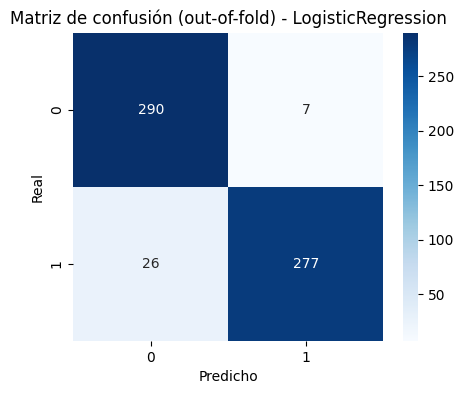

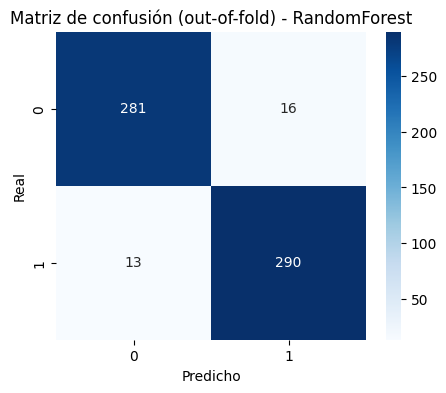

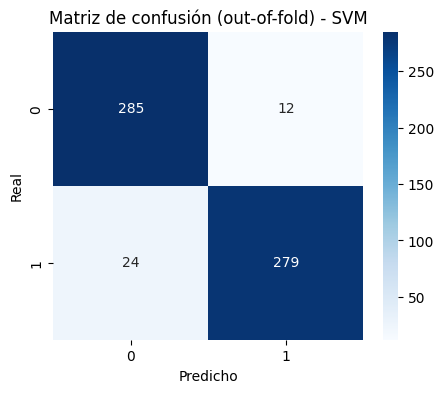

In [18]:
# Ejemplos extendidos de validación cruzada
from sklearn.calibration import cross_val_predict
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# cross_val_predict para obtener predicciones 'out-of-fold' y calcular matriz de confusión
for name, model in models.items():
    y_oof = cross_val_predict(model, X, y, cv=cv)
    cm = confusion_matrix(y, y_oof)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de confusión (out-of-fold) - {name}')
    plt.xlabel('Predicho')
    plt.ylabel('Real')
    plt.show()